In [22]:
import requests
import pandas as pd
import json
import io
import itertools
import datetime
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
full_game_logs_df = pd.read_csv('data-full/2021_22_NBA_REG_GAME_LOGS_COMBINED.csv')

In [16]:
full_game_logs_df

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
0,2021-22,203497,Rudy Gobert,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,198,11,21,19.0,0.0,0.169333,0.200000,24,16,0
1,2021-22,203903,Jordan Clarkson,1610612762,UTA,Utah Jazz,22101230,2022-04-10T00:00:00,UTA @ POR,W,...,167,1,5,7.0,0.0,0.139000,0.223667,7,70,0
2,2021-22,1628384,O.G. Anunoby,1610612761,TOR,Toronto Raptors,22101226,2022-04-10T00:00:00,TOR @ NYK,L,...,0,0,0,0.0,0.0,0.000000,0.000000,22,9,0
3,2021-22,1627751,Jakob Poeltl,1610612759,SAS,San Antonio Spurs,22101219,2022-04-10T00:00:00,SAS @ DAL,L,...,116,7,8,11.0,1.0,0.157500,0.236000,12,3,0
4,2021-22,1630170,Devin Vassell,1610612759,SAS,San Antonio Spurs,22101219,2022-04-10T00:00:00,SAS @ DAL,L,...,200,4,4,4.0,2.0,0.131667,0.182000,9,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6541,2021-22,201939,Stephen Curry,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,58,158,0
6542,2021-22,1629673,Jordan Poole,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,2,598,0
6543,2021-22,203110,Draymond Green,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,45,158,0
6544,2021-22,203952,Andrew Wiggins,1610612744,GSW,Golden State Warriors,22100002,2021-10-19T00:00:00,GSW @ LAL,W,...,0,0,0,0.0,0.0,0.000000,0.000000,13,158,0


In [17]:
full_game_logs_df.columns

Index(['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'PTS', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME'],
      dtype='object')

In [18]:
game_logs_subset = ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'PFD', 'PTS', 'USG_PCT', 'PIE',
       'POSS', 'PTS_PAINT', 'PCT_PTS_2PT_MR', 'AGE', 'PLAYER_HEIGHT_INCHES',
       'PLAYER_WEIGHT', 'FGM_PAINT', 'FGM_2PT_MR', 'PW_MIN', 'PW_GAMES',
       'PW_FG3A', 'PW_FG2A', 'PW_OREB', 'PW_DREB', 'PW_ASTS', 'PW_TOV',
       'PW_STL', 'PW_BLK', 'PW_POS', 'PW_PF', 'PW_PFD', 'PW_FGM_PAINT',
       'PW_FGM_2PT_MR', 'PW_PIE_AVG', 'PW_USG_PCT_AVG', 'CAREER_INJURIES',
       'DAYS_LAST_INJURY', 'OUT_NEXT_GAME']

In [19]:
game_logs_data = full_game_logs_df[game_logs_subset]

In [20]:
game_logs_data

,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
0,29.633333,4,6,0,0,10,14,3,10,1,...,198,11,21,19.0,0.0,0.169333,0.200000,24,16,0
1,28.600000,4,13,1,8,0,0,3,8,4,...,167,1,5,7.0,0.0,0.139000,0.223667,7,70,0
2,25.450000,3,9,0,5,2,2,2,7,3,...,0,0,0,0.0,0.0,0.000000,0.000000,22,9,0
3,28.666667,6,11,0,0,0,0,4,6,0,...,116,7,8,11.0,1.0,0.157500,0.236000,12,3,0
4,31.500000,4,11,3,8,4,4,1,3,3,...,200,4,4,4.0,2.0,0.131667,0.182000,9,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6541,36.183333,5,21,2,8,9,9,1,9,10,...,0,0,0,0.0,0.0,0.000000,0.000000,58,158,0
6542,25.066667,8,18,4,11,0,1,0,2,3,...,0,0,0,0.0,0.0,0.000000,0.000000,2,598,0
6543,29.938333,2,5,0,0,2,4,3,5,6,...,0,0,0,0.0,0.0,0.000000,0.000000,45,158,0
6544,25.733333,5,10,2,5,0,0,1,6,1,...,0,0,0,0.0,0.0,0.000000,0.000000,13,158,0


In [21]:
game_logs_data.corr()

,MIN,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,AST,...,PW_POS,PW_PF,PW_PFD,PW_FGM_PAINT,PW_FGM_2PT_MR,PW_PIE_AVG,PW_USG_PCT_AVG,CAREER_INJURIES,DAYS_LAST_INJURY,OUT_NEXT_GAME
MIN,1.000000,0.518593,0.608250,0.240932,0.312010,0.349521,0.356537,0.095261,0.291103,0.379717,...,0.202770,0.080586,0.268620,0.210391,0.236723,0.196663,0.255916,0.102837,-0.018181,-0.091352
FGM,0.518593,1.000000,0.819176,0.401999,0.292118,0.373288,0.386613,0.120633,0.267941,0.268270,...,0.136302,0.059529,0.356813,0.340448,0.300841,0.288177,0.394548,0.079685,-0.029384,-0.028240
FGA,0.608250,0.819176,1.000000,0.368437,0.510324,0.418614,0.418409,0.064985,0.205735,0.347675,...,0.149143,0.041314,0.365431,0.289262,0.362156,0.260141,0.491379,0.067488,-0.032548,-0.021482
FG3M,0.240932,0.401999,0.368437,1.000000,0.777771,0.019599,-0.015950,-0.236510,-0.113305,0.105456,...,0.037501,-0.069161,-0.049447,-0.148402,0.036952,-0.064563,0.104364,-0.018461,-0.006756,-0.023735
FG3A,0.312010,0.292118,0.510324,0.777771,1.000000,0.055580,0.015957,-0.289188,-0.149795,0.168202,...,0.052812,-0.080306,-0.041156,-0.183129,0.053244,-0.070011,0.181910,-0.027019,-0.014426,-0.023960
FTM,0.349521,0.373288,0.418614,0.019599,0.055580,1.000000,0.957129,0.084561,0.227475,0.230431,...,0.086082,0.053003,0.412727,0.281576,0.240388,0.286250,0.350169,0.116161,-0.052554,-0.008313
FTA,0.356537,0.386613,0.418409,-0.015950,0.015957,0.957129,1.000000,0.136398,0.270000,0.218620,...,0.082175,0.067206,0.432734,0.315792,0.213510,0.300411,0.348289,0.114639,-0.049906,-0.010138
OREB,0.095261,0.120633,0.064985,-0.236510,-0.289188,0.084561,0.136398,1.000000,0.317061,-0.087881,...,0.003080,0.130314,0.116504,0.253829,-0.105943,0.173395,-0.029297,0.000700,0.005369,-0.020869
DREB,0.291103,0.267941,0.205735,-0.113305,-0.149795,0.227475,0.270000,0.317061,1.000000,0.095661,...,0.049477,0.135334,0.261246,0.309832,0.047321,0.311458,0.147159,0.091300,0.042182,-0.037476
AST,0.379717,0.268270,0.347675,0.105456,0.168202,0.230431,0.218620,-0.087881,0.095661,1.000000,...,0.104517,-0.010384,0.240075,0.125859,0.261829,0.207011,0.274306,0.155192,-0.051418,-0.001282


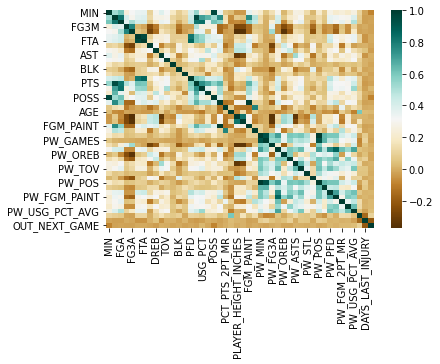

In [27]:
sns.heatmap(game_logs_data.corr(), cmap='BrBG');

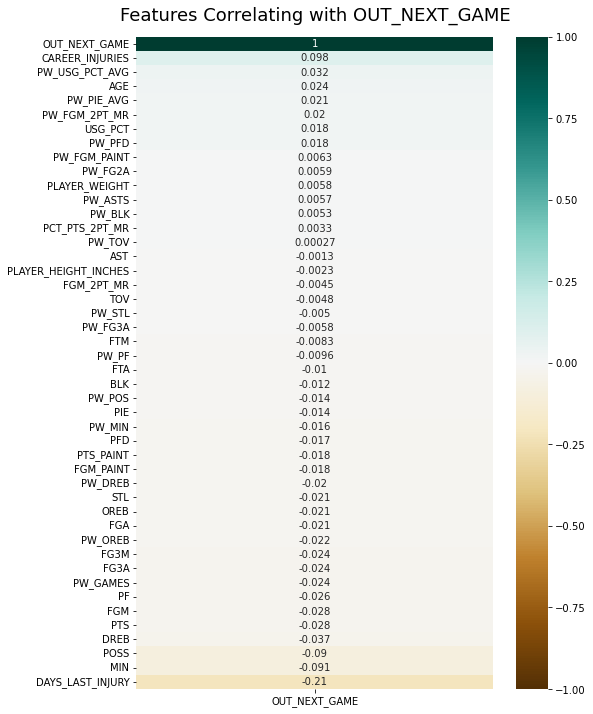

In [26]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(game_logs_data.corr()[['OUT_NEXT_GAME']].sort_values(by='OUT_NEXT_GAME', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with OUT_NEXT_GAME', fontdict={'fontsize':18}, pad=16);